In [28]:
import numpy as np
import os
import time
from resnet50 import ResNet50
from keras.preprocessing import image
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten

from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

In [29]:
IMAGE_SIZE = 224

In [30]:
# Loading the training data
PATH = os.getcwd()

# Define data path
data_path = PATH + '/dataset/indian-food'
data_dir_list = os.listdir(data_path)

img_data_list=[]

for dataset in sorted(data_dir_list):
    img_list=os.listdir(data_path+'/'+ dataset)[:100]
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        img_path = data_path + '/'+ dataset + '/'+ img 
        img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        # print('Input image shape:', x.shape)
        img_data_list.append(x)

Loaded the images of dataset-briyani

Loaded the images of dataset-dhosa

Loaded the images of dataset-gulab-jamun

Loaded the images of dataset-jalebi

Loaded the images of dataset-momo

Loaded the images of dataset-samosa

Loaded the images of dataset-tantoori-chicken



In [31]:
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
print(img_data.shape)

(700, 224, 224, 3)


In [32]:
# Define the number of classes
num_classes = 7
num_of_samples = (img_data.shape[0])
labels = np.ones((num_of_samples,), dtype='int64')

labels[:101]=0
labels[101:201]=1
labels[201:301]=2
labels[301:401]=3
labels[401:501]=4
labels[501:601]=5
labels[601:]=6

names = ['briyani', 'dhosa', 'gulab-jamun', 'jalebi', 'momo', 'samosa', 'tantoori-chicken']
# convert class Labels to one-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

# Shuffle the dataset
x, y= shuffle(img_data, Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [33]:
model = ResNet50(weights='imagenet', include_top=False)

In [34]:
last_layer = model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(last_layer)

# Add fully connected & dropout layers
x = Dense(512, activation='relu', name='fc-1')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', name='fc-2')(x)
x = Dropout(0.5)(x)

# softmax layer for 5 classes
out = Dense(num_classes, activation='softmax', name='output_layer')(x)

custom_resnet_model2 = Model(model.input, outputs=out)

for layer in custom_resnet_model2.layers[:-10]:
    layer.trainable = False
    
custom_resnet_model2.layers[-1].trainable

True

In [35]:
custom_resnet_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# training model
t=time.time()
hist = custom_resnet_model2.fit(X_train, y_train, batch_size=32, epochs=11, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s secs' % (time.time() - t ))

Train on 560 samples, validate on 140 samples
Epoch 1/11
560/560 [==============================] - 402s 718ms/step - loss: 1.8919 - acc: 0.3393 - val_loss: 0.7703 - val_acc: 0.7857
Epoch 2/11
560/560 [==============================] - 372s 664ms/step - loss: 1.0028 - acc: 0.6554 - val_loss: 0.4223 - val_acc: 0.8786
Epoch 3/11
560/560 [==============================] - 365s 653ms/step - loss: 0.5949 - acc: 0.8054 - val_loss: 0.4749 - val_acc: 0.8357
Epoch 4/11
560/560 [==============================] - 371s 662ms/step - loss: 0.5137 - acc: 0.8429 - val_loss: 0.3607 - val_acc: 0.8929
Epoch 5/11
560/560 [==============================] - 367s 655ms/step - loss: 0.4225 - acc: 0.8607 - val_loss: 0.3644 - val_acc: 0.8429
Epoch 6/11
560/560 [==============================] - 366s 654ms/step - loss: 0.3895 - acc: 0.8911 - val_loss: 0.3054 - val_acc: 0.8643
Epoch 7/11
560/560 [==============================] - 363s 649ms/step - loss: 0.3019 - acc: 0.9161 - val_loss: 0.4302 - val_acc: 0.8714
Ep

In [36]:
(loss, accuracy) = custom_resnet_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)
print('[INFO] loss = {:.4f}, accuracy: {:.4f}%'.format(loss, accuracy * 100))

140/140 [==============================] - 84s 599ms/step
[INFO] loss = 0.3125, accuracy: 91.4286%


In [37]:
import matplotlib.pyplot as plt

In [40]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']
xc = range(11)

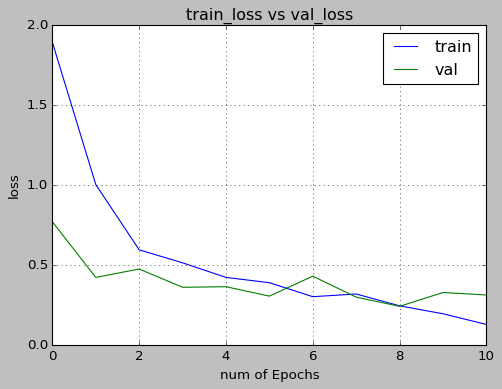

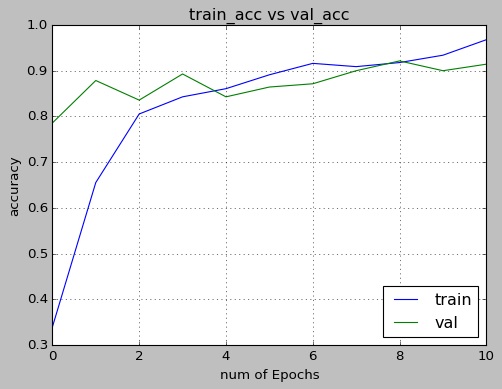

In [41]:
plt.figure(1, figsize=(7, 5))
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train', 'val'])
plt.style.use(['classic'])

plt.figure(2, figsize=(7, 5))
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train', 'val'], loc=4)
plt.style.use(['classic'])
plt.show()

In [42]:
custom_resnet_model2.save_weights('model/keras/FIC-In-{C7}-{B32}-{E11}.h5', overwrite=True)

# Serialize model to JSON
model_json = custom_resnet_model2.to_json()
with open('model/keras/FIC-In-{C7}-{B32}-{E11}.h5.json', 'w') as json_file:
    json_file.write(model_json)

In [43]:
import pandas as pd

Input image shape: (1, 224, 224, 3)
Image: 


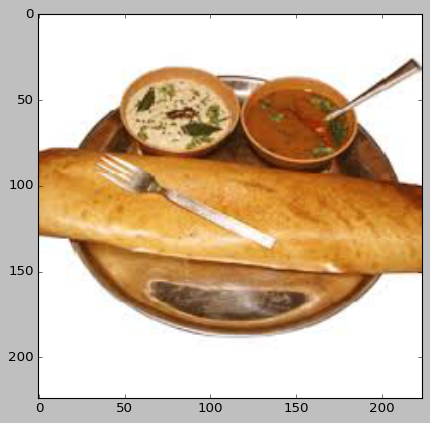


Prediction:

              Class  Prob-percent
0           briyani      0.000021
1             dhosa     99.896848
2       gulab-jamun      0.000192
3            jalebi      0.000095
4              momo      0.000013
5            samosa      0.102823
6  tantoori-chicken      0.000009
--------------------------------------------------------------------------


Input image shape: (1, 224, 224, 3)
Image: 


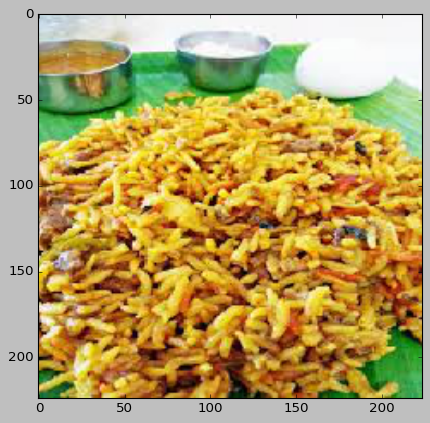


Prediction:

              Class  Prob-percent
0           briyani     99.980754
1             dhosa      0.000006
2       gulab-jamun      0.000020
3            jalebi      0.018695
4              momo      0.000371
5            samosa      0.000003
6  tantoori-chicken      0.000150
--------------------------------------------------------------------------


Input image shape: (1, 224, 224, 3)
Image: 


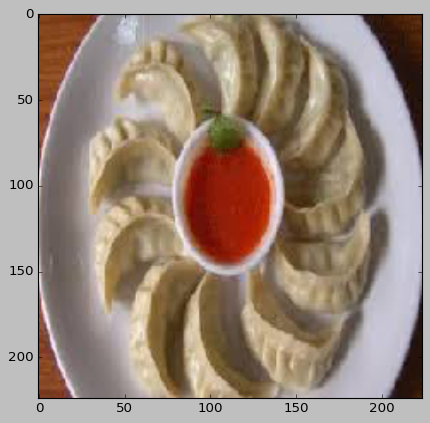


Prediction:

              Class  Prob-percent
0           briyani  1.449522e-05
1             dhosa  7.642362e-05
2       gulab-jamun  4.902279e-04
3            jalebi  1.098101e-02
4              momo  9.998796e+01
5            samosa  4.827257e-04
6  tantoori-chicken  6.353632e-07
--------------------------------------------------------------------------




In [44]:
images = ['dhosa_115.jpg', 'briyani_122.jpg', 'momo_478.jpg']
for img in images:
    img_path = os.path.join('images', img)
    img = image.load_img(img_path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    print('Input image shape:', x.shape)

    preds = custom_resnet_model2.predict(x)

    print('Image: ')
    plt.imshow(img)
    plt.show()

    print('\nPrediction:', end='\n\n')
    preds = preds[0]
    prob_dist = []
    for i in range(len(preds)):
        prob_dist.append([names[i], preds[i]*100])
    df = pd.DataFrame(prob_dist, columns=['Class', 'Prob-percent'])
    print(df)
    print('--------------------------------------------------------------------------', end='\n\n\n')